In [1]:
import Agent_Library
from   Agent_Library import np, plt, Camera, tf, nx

import random
import pandas as pd
from openpyxl import Workbook

import importlib

# import psutil
# import cProfile, pstats
# import snakeviz.cli as cli
# %load_ext snakeviz

In [2]:
def Initializer(N, L, Alphas=[-0.5,0.1,0.2,-0.5], seed=42, requesting=False, moving=False, training=False):
    importlib.reload(Agent_Library)
    np.random.seed(seed)
    random.seed(seed)
    # -----------------------------------------------------------------------------------
    camera = Camera(plt.figure(figsize=(15,15)))

    # Build the environment and the agents ----------------------------------------------
    Agents = []
    for _ in range(N): 
        Agents.append(Agent_Library.Distributed_Agent(N, L, Alphas, requesting=requesting, moving=moving, training=training))
    
    environment = Agent_Library.Plot_Environment(L, Agents)

    
    return camera, environment, Agents

In [3]:
def ExportResults(step, environment, Agents, AveragedExcel, ParticleExcel):
    environment.Environmental_Changes(Agents)
    G = nx.from_numpy_array(environment.A)
    Giant = sorted(nx.connected_components(G), key=len, reverse=True)
     
    # Show Averaged Results ---------------------------------------------------------------------
    # step	Hamilton	Giant	Edges	Energy	Tau	R_avg loss ----------------------------------
    hamilton, edge, energy, average_r, giant, tau = environment.Calculate_Result(Agents, step)
    loss = 0; 
    for i in range(len(Agents)): loss += Agents[i].loss.numpy()
    AveragedExcel.append([step, hamilton, giant, edge, energy, tau, average_r, loss])


    # Show Particle Results ---------------------------------------------------------------------
    # step	index	X	Y	Component	r	k	rho	Energy	connected_to ------------------------
    # state   action  reward  next_state    loss ------------------------------------------------
    for i in range(len(Agents)):
        particle_hamilton = Agents[i].Hamiltonian()
        particle_k, particle_r, particle_rho = Agents[i].MyState()
        state, action, reward, next_state    = Agents[i].replay_memory[-1]

        for j in range(len(Giant)):
            if i in Giant[j]: component = j

        co = []
        for j in range(len(Agents)):
            if environment.A[i][j] == 1: co.append(j) 

        ParticleExcel.append([step, i, Agents[i].x, Agents[i].y, component, 
                                particle_r, particle_k, particle_rho, particle_hamilton, str(co), 
                                str(state), action, reward, str(next_state), Agents[i].loss.numpy()])

# MAIN

In [4]:
def base_model(seed, ParticleExcel, AveragedExcel):
    N = 100                      # Number of agents
    L = 14                       # The length of the simulation box
    _, environment, Agents = Initializer(N, L, seed)

    ParticleExcel_ = ParticleExcel.create_sheet(title=f'Base')
    AveragedExcel_ = AveragedExcel.create_sheet(title=f'Base')
    ParticleExcel_.append(["step", "index", "X", "Y", "Component", "r", "k", "rho", "Hamilton", "connected to"])
    AveragedExcel_.append(["step", "Hamilton", "Giant", "Edges", "Energy", "Tau", "R_avg"])

    for step in range(1001):
        for i in range(len(Agents)):
            Agents[i].N = len(Agents)
            Agents[i].OtherAgents = (Agents[:i] + Agents[i+1:])
            if Agents[i].k < 5: action = np.random.randint(2)
            else: action = 0
        
            _, _ = Agents[i].step(action)


        ExportResults(step, environment, Agents, AveragedExcel_, ParticleExcel_)
            
            
        # -------------------------------------------------------------------------------------------
        print("\rSeed: {}, Step: {}".format(seed, step), end="")


In [5]:
def AI_model(seed, Alphas, ParticleExcel, AveragedExcel, requesting):
    N = 100                      # Number of agents
    L = 45                       # The length of the simulation box
    _, environment, Agents = Initializer(N, L, Alphas, seed, requesting=requesting, moving=True, training=True)


    if requesting:  sheet_name = "Send Request"
    else:           sheet_name = "Just Model"

    ParticleExcel_ = ParticleExcel.create_sheet(title=sheet_name)
    AveragedExcel_ = AveragedExcel.create_sheet(title=sheet_name)
    ParticleExcel_.append(["step", "index", "X", "Y", "Component", "r", "k", "rho", "Hamilton", "connected to"
                           , "state", "action", "reward", "next_state", "loss"])
    AveragedExcel_.append(["step", "Hamilton", "Giant", "Edges", "Energy", "Tau", "R_avg", "loss"])


    for step in range(1001):
        for i in range(len(Agents)):
            Agents[i].Prediction( (Agents[:i] + Agents[i+1:]) )

        
        # -------------------------------------------------------------------------------------------
        ExportResults(step, environment, Agents, AveragedExcel_, ParticleExcel_)
        print("\rSeed: {}, Step: {}".format(seed, step), end="")


In [ ]:
for seed in range(34, 35):
    
    # ParticleExcel = pd.ExcelWriter(f"./All result/csv/Particle data {seed}.xlsx", engine='openpyxl')
    # AveragedExcel = pd.ExcelWriter(f"./All result/csv/Averaged data {seed}.xlsx",  engine='openpyxl')
    ParticleExcel = Workbook(); del ParticleExcel['Sheet']
    AveragedExcel = Workbook(); del AveragedExcel['Sheet']

    Alphas = [-0.5, +0.3, 1.0, -1000]

    # df_base   = base_model(seed, ParticleExcel, AveragedExcel)       ;      print("  finish Base...")
    df_AI     =   AI_model(seed, Alphas, ParticleExcel, AveragedExcel, False);      print("  finish False...") 
    df_AI_Req =   AI_model(seed, Alphas, ParticleExcel, AveragedExcel, True );      print("  finish True!")
    

    ParticleExcel.save(f"./All Results/Datas/data {seed}/{seed} Particle Data - Movement & Train 0.001 & alpha4=-1000.xlsx")
    AveragedExcel.save(f"./All Results/Datas/data {seed}/{seed} Averaged Data - Movement & Train 0.001 & alpha4=-1000.xlsx")

    # ParticleExcel.close()
    # AveragedExcel.close()
    

# Learning Model

In [4]:
def Learning_Initializer(N, L, Alphas=[-0.5,0.1,0.2,-0.5], seed=42, requesting=False, moving=False, training=False):
    importlib.reload(Agent_Library)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # ----------------------------------------------------------------------------------------
    camera = Camera(plt.figure(figsize=(15,15)))

    # Build the environment and the agents ---------------------------------------------------
    Agents = []
    for _ in range(N): 
        Agents.append(Agent_Library.Distributed_Agent(N, L, Alphas, requesting=requesting, moving=moving, training=training))
    
    environment = Agent_Library.Plot_Environment(L, Agents)

    # Build Model ----------------------------------------------------------------------------
    tf.keras.backend.clear_session()

    inputs = tf.keras.layers.Input(shape=(3,), name='input') 
    x = tf.keras.layers.Dense(32, activation='elu', name='dense_1')(inputs) 
    x = tf.keras.layers.Dense(32, activation='elu', name='dense_2')(x) 
    outputs = tf.keras.layers.Dense(2, activation=Agents[0].custom_activation, name='output')(x) 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    for i in range(N): 
        Agents[i].model = model
        Agents[i].OtherAgents = (Agents[:i] + Agents[i+1:])


    # Exporte Files --------------------------------------------------------------------------
    ParticleExcel = Workbook(); del ParticleExcel['Sheet']
    AveragedExcel = Workbook(); del AveragedExcel['Sheet']
    ParticleExcel_ = ParticleExcel.create_sheet(title=f'Learning')
    AveragedExcel_ = AveragedExcel.create_sheet(title=f'Learning')
    ParticleExcel_.append(["step", "index", "X", "Y", "Component", "r", "k", "rho", "Hamilton", "connected to"
                           , "state", "action", "reward", "next_state", "loss", "H2G2"])
    AveragedExcel_.append(["step", "Hamilton", "Giant", "Edges", "Energy", "Tau", "R_avg", "loss"])

    # LogExcel  = Workbook(); del LogExcel['Sheet']
    # LogExcel_ = LogExcel.create_sheet(title=f'Learning')
    # LogExcel_.append(["step", "index", "X", "Y", "r", "k", "rho", "Hamilton", "state", "action", "reward", "next_state",
    #                 "all_Q_values", "Q_values", "next_Q_values", "target_Q_values", "loss",
    #                 "g1" , "g2", "g3", "g4", "g5" , "g6", "var1" , "var2", "var3", "var4", "var5" , "var6"])

    
    return camera, environment, Agents, AveragedExcel, AveragedExcel_, ParticleExcel, ParticleExcel_

In [5]:
def logPrint(step, i, Agents, Train_Values, LogExcel):

    # Show Particle Results ------------------------------------------------------------------------
    # step	index	X	Y	r	k	rho	Hamiltonian ------------------------
    # state   action  reward  next_state -----------------------------------------------------------
    # all_Q_values  next_Q_values   Q_values    target_Q_values loss -------------------------------
    
    # for i in range(len(Agents)):
    k, r, rho = Agents[i].MyState()
    hamilton  = Agents[i].Hamiltonian()
    state, action, reward, next_state = Agents[i].replay_memory[-1]

    all_Q, Q, next_Q, target_Q, loss, grads, trainable_variables = Train_Values

        
    mat = [step, i, Agents[i].x, Agents[i].y, r, k, rho, hamilton, str(state), action, reward, str(next_state),
            str(all_Q.numpy().ravel()), str(Q.numpy().ravel()), str(next_Q.numpy().ravel()), str(target_Q.ravel()), loss.numpy() ]
    for grad     in grads:               mat.append(str(grad    .numpy().ravel()))
    for variable in trainable_variables: mat.append(str(variable.numpy().ravel()))

    
    LogExcel.append(mat)


In [7]:
def Saving(path, ParticleExcel, AveragedExcel, H_best_weight, G_best_weight, H2G2_best_weight, last_weight, custom_activation):
    inputs = tf.keras.layers.Input(shape=(3,), name='input') 
    x = tf.keras.layers.Dense(32, activation='elu', name='dense_1')(inputs) 
    x = tf.keras.layers.Dense(32, activation='elu', name='dense_2')(x) 
    outputs = tf.keras.layers.Dense(2, activation=custom_activation, name='output')(x) 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    ParticleExcel.save(f"{path}/Particle Data -1000 L=45.xlsx")
    AveragedExcel.save(f"{path}/Averaged Data -1000 L=45.xlsx")
    # LogExcel     .save(f"{path}/Log Data.xlsx")


    model_H_best_weight    = model;    model_H_best_weight.set_weights(H_best_weight)
    model_G_best_weight    = model;    model_G_best_weight.set_weights(G_best_weight)
    model_H2G2_best_weight = model;    model_H2G2_best_weight.set_weights(H2G2_best_weight)
    model_last_weight      = model;    model_last_weight.set_weights(last_weight)

    model_H_best_weight   .save(f'{path}/model_H_best_weight.keras')
    model_G_best_weight   .save(f'{path}/model_G_best_weight.keras')
    model_H2G2_best_weight.save(f'{path}/model_H2G2_best_weight.keras')
    model_last_weight     .save(f'{path}/model_last_weight.keras')

In [8]:
N = 100                      # Number of agents
L = 45                       # The length of the simulation box
Alphas = [-0.5, +0.3, 1.0, -1000]
camera, environment, Agents, AveragedExcel, AveragedExcel_, ParticleExcel, ParticleExcel_ = Learning_Initializer(N, L, Alphas)

best_H, best_G, best_H2G2 = 0, 0, 0
H_best_weight, G_best_weight, H2G2_best_weight = 0, 0, 0


# -----------------------------------------------------------------------------------------------
for step in range(1001):
    
    epsilon = max(1 - step/500, 0.0)             # first is more random and than use greedy
    for _ in range(10):
    # Like play_one_step function ---------------------------------------------------------------
        for i in range(len(Agents)):

            if np.random.rand() < epsilon:
                state  = [s+1 for s in Agents[i].MyState()]
                action = np.random.randint(2)
                STEP   = Agents[i].step((action-0.5)*2)
                reward = STEP[1]
                next_state = [ns+1 for ns in STEP[0]]

                Agents[i].replay_memory.append((state, action, reward, next_state))

            else: 
                Agents[i].Prediction( (Agents[:i] + Agents[i+1:]) )


    # Result Section ----------------------------------------------------------------------------       
    ExportResults(step, environment, Agents, AveragedExcel_, ParticleExcel_)
    hamilton, edge, energy, average_r, giant, tau = environment.Calculate_Result(Agents, step)

    # Find Best Weights -------------------------------------------------------------------------     
    if step > 500:
        if hamilton <= best_H:                                  # find the minimum of Hamiltonian
            H_best_weight    = Agents[0].model.get_weights()    # saving model weights for the best Hamiltonian
            best_H = hamilton

        if giant >= best_G:
            G_best_weight    = Agents[0].model.get_weights()    # saving model weights for the best Giant Component
            best_G = giant

        if np.sqrt(hamilton**2 + giant**2) >= best_H2G2:
            H2G2_best_weight = Agents[0].model.get_weights()
            best_H2G2 = np.sqrt(hamilton**2 + giant**2)



    # Train Section -----------------------------------------------------------------------------
    if step > 50:
        for i in range(N):
            Agents[i].Train(batch_size=20, learning_rate=1e-5)
            if i != N-1: Agents[i+1].model = Agents[i].model

        for i in range(N-1): Agents[i].model = Agents[N-1].model


    print("\rStep: {}, Epsilon: {:.3f}, H: {:.2f}, Giant: {:.1f}, Min(Hamilton): {:.2f}, Max(Giant): {:.1f}"
          .format(step, epsilon, hamilton, giant, best_H, best_G), end="")

last_weight = Agents[0].model.get_weights()


# Save ------------------------------------------------------------------------------------------
path = "./All result/models with alpha4 = -1000/L=45"
Saving(path, ParticleExcel, AveragedExcel , H_best_weight, G_best_weight, H2G2_best_weight, last_weight, Agents[0].custom_activation)



Step: 6, Epsilon: 0.988, H: -109378.58, Giant: 15.0, Min(Hamilton): 0.00, Max(Giant): 0.0

c:\Users\Mehdi\Desktop\Desktop\code\project\Agent_Library.py:112: RuntimeWarning: overflow encountered in exp
  if np.exp(-delta_H/4) < np.random.random():     # delta_H < 0 --> f(x) > 1;


Step: 1000, Epsilon: 0.000, H: -213415.41, Giant: 100.0, Min(Hamilton): -215471.09, Max(Giant): 100.0

<Figure size 1500x1500 with 0 Axes>

# Make Animation

In [10]:
import ast
N = 100
L = 45

        
result = pd.read_excel(f"./All result/Different Model Training/models with alpha4 = -1000/L=45/Particle Data -1000 L=45.xlsx", sheet_name='Learning')
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=None, hspace=None)
camera = Camera(fig)

for step in range(1001):
    df = result["connected to"][step*N:(step+1)*N].apply(lambda cell: ast.literal_eval(cell))        # string to list

    A = np.zeros((N, N))
    for i in range(N):
        for l in df[step*N + i]:
            A[i][l] = 1

    # Ploting -------------------------------------------------------------------------------
    if step%5==0:
        G = nx.from_numpy_array(A)

        options = { 'node_size': 60, 'width': 1.5, 'node_color': (0.5,0.0,0.8,1) }
        for i in range(N): G.add_node(i, pos=(result["X"][step*N+i], result["Y"][step*N+i]))
        pos = nx.get_node_attributes(G, 'pos')
        poss = dict( (i, ( result["X"][step*N+i]+0.2, result["Y"][step*N+i]+0.1 )) for i in range(N))
        nx.draw_networkx_labels(G, poss, font_size=10.5, font_weight='bold', font_color='k')

        nx.draw_networkx(G, pos, with_labels=False, **options)

        plt.text(L-0.1*L, L+0.5, f'Episode {step}', fontname='Comic Sans MS', fontsize=13)
        plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.xlim(-0.3, L+0.3); plt.ylim(-0.3, L+0.3)
        plt.grid(alpha=0.3)
        
        camera.snap()

anim = camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=True)
anim.save(f'./All result/Different Model Training/models with alpha4 = -1000/L=45/Animation - Training.gif')
print()

del result
plt.close(fig)

d:\Applications\Anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
import ast
N = 100
L = 14

sheets = ['Just Model', 'Send Request']
for seed in range(30,31):
    for sheet in sheets:
        
        result = pd.read_excel(f"./datas/data {seed}/{seed} Particle Data - Movement & Train.xlsx", sheet_name=sheet)

        fig = plt.figure(figsize=(14,14))
        fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=None, hspace=None)
        camera = Camera(fig)

        for step in range(1001):
            df = result["connected to"][step*N:(step+1)*N].apply(lambda cell: ast.literal_eval(cell))        # string to list

            A = np.zeros((N, N))
            for i in range(N):
                for l in df[step*N + i]:
                    A[i][l] = 1

            # Ploting -------------------------------------------------------------------------------
            if step%5==0:
                G = nx.from_numpy_array(A)

                options = { 'node_size': 60, 'width': 1.5, 'node_color': (0.5,0.0,0.8,1) }
                for i in range(N): G.add_node(i, pos=(result["X"][step*N+i], result["Y"][step*N+i]))
                pos = nx.get_node_attributes(G, 'pos')
                poss = dict( (i, ( result["X"][step*N+i]+0.2, result["Y"][step*N+i]+0.1 )) for i in range(N))
                nx.draw_networkx_labels(G, poss, font_size=10.5, font_weight='bold', font_color='k')

                nx.draw_networkx(G, pos, with_labels=False, **options)

                plt.text(L-0.1*L, L+0.5, f'Episode {step}', fontname='Comic Sans MS', fontsize=13)
                plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
                plt.xlim(-0.3, L+0.3); plt.ylim(-0.3, L+0.3)
                plt.grid(alpha=0.3)
                
                camera.snap()

            print("\rSeed: {}, Sheep: {}".format(seed, sheet), end="")

        anim = camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=True)
        anim.save(f'./datas/data {seed}/{seed} Animation - Movement & Train -- {sheet}.gif')
        print()

        del result
        plt.close(fig)

SyntaxError: incomplete input (4155730282.py, line 49)

# Test

In [ ]:
# with cProfile.Profile() as profile: main()
# stats = pstats.Stats(profile).sort_stats('cumtime')
# stats.dump_stats("./All result/cProFile/cProFile.prof")

# stats.print_stats()
# cli.main(["./All result/cProFile/cProFile.prof"])

In [ ]:
result = pd.read_excel(f"./All result/models with alpha4 = -1000/Log Data.xlsx", sheet_name='Learning')

# --------------------------------------------------------------------------
LOSS = []
for i in range(750): LOSS.append(sum(result['loss'][i*100:(i+1)*100])/100.)

plt.plot(np.linspace(51,800,750) , LOSS)
plt.grid(alpha = 0.3)
plt.show()

# --------------------------------------------------------------------------
los = (pd.DataFrame(LOSS))
los.to_csv("loss.csv")

tf.Tensor(0.0, shape=(), dtype=float32)


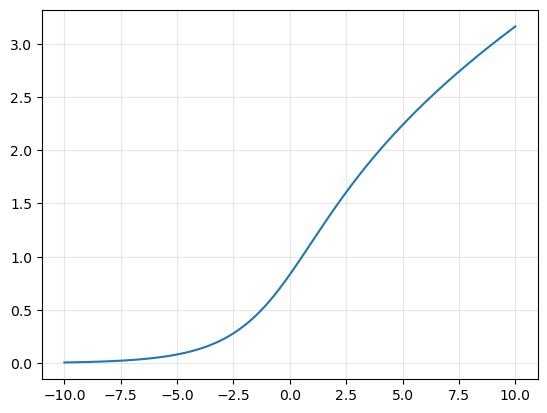

In [55]:
N = 100                      # Number of agents
L = 14                       # The length of the simulation box
# camera, environment, Agents, Hamilton, Giant, Edges, Energy, R_avg, Tau = Initializer(N, L, 30)

def custom_activation(x):
    xx = (tf.keras.backend.softplus(x))**0.5
    return -tf.keras.backend.elu(-xx + 100) + 100

print(custom_activation(-40.))

X = np.linspace(-10,10,1000)
Y = custom_activation(X)

plt.plot(X,Y)
plt.grid(alpha=0.3)
plt.show()
